# Path Tracing Notebook
The first 5 code cells are required only on Google Colab. Ignore them if you are running the notebook from your local machine.

In [1]:
# 1. Run only if you need to delete cached folder from Google Colab
!rm -rf /content/light-transport

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# 2. Download the project files from Github
!git clone https://github.com/dipanjan92/light-transport.git

Cloning into 'light-transport'...


In [3]:
# 3. Add the project directory to the system PATH
import sys
sys.path.insert(0,'/content/light-transport/LightTransportSimulator')

In [4]:
# 4. PyVista is used to generate 3D objects
!pip install pyvista

In [5]:
# 5. Switch to project directory
import os
os.chdir('/content/light-transport/')
os.getcwd()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/light-transport/'

********************************************************************************************

In [69]:
import math
import shutil
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv

In [70]:
from primitives.triangle import Triangle
from scenes.scene import Scene
from scenes.render import render_scene
from utils.misc import get_floor

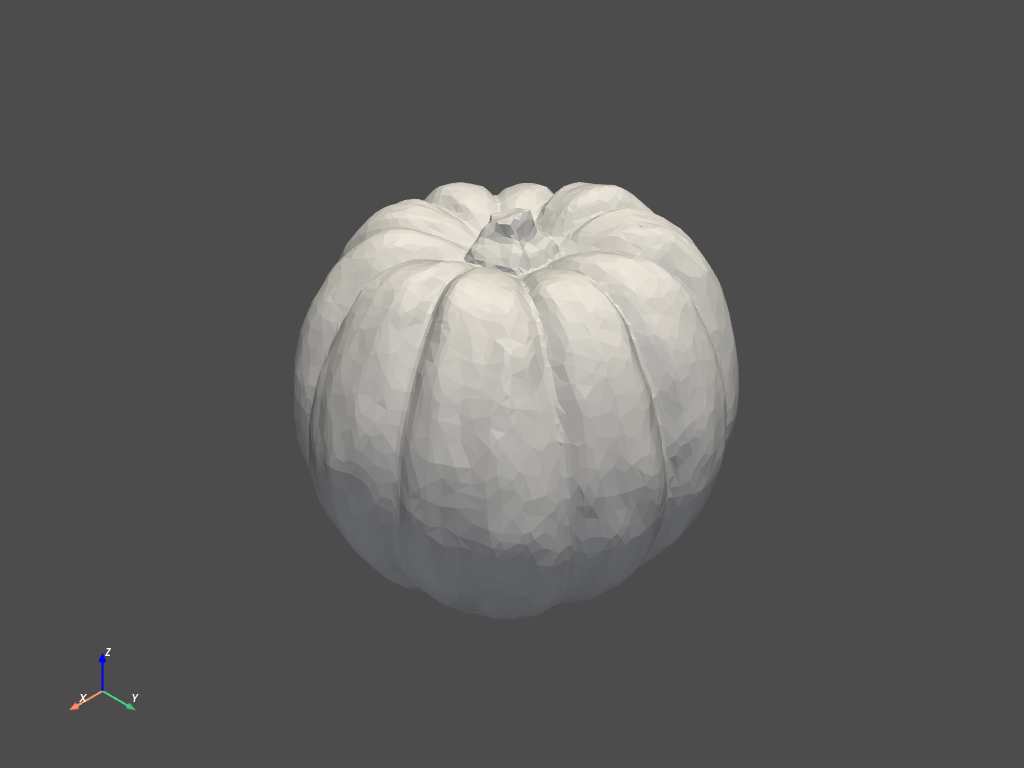

In [71]:
#load object
path = Path("objects/pumpkin.obj").resolve()
mesh = pv.read(path)
mesh.plot()


In [72]:
mesh = mesh.triangulate()
points = np.ascontiguousarray(mesh.points)
points

array([[   3.26843,  -28.8491 , -135.4834 ],
       [   4.96375,  -28.2603 , -135.8396 ],
       [   5.76222,  -27.3298 , -136.4636 ],
       ...,
       [ -17.6027 ,   29.3317 , -131.41049],
       [ -15.588  ,   29.0676 , -133.4489 ],
       [  -4.509  ,    3.664  ,  -78.8437 ]], dtype=float32)

In [73]:
points = np.ascontiguousarray(mesh.points)
faces = mesh.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)

In [74]:
# Initialise an empty list for primitives
objects = numba.typed.List()

In [75]:
# Add the triangles in the list of objects
for v in vertices:
    a,b,c = v[0], v[1], v[2]

    triangle = Triangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64))
    objects.append(triangle)

objects

ListType[instance.jitclass.Triangle#17fd5391300<vertex_1:array(float64, 1d, A),vertex_2:array(float64, 1d, A),vertex_3:array(float64, 1d, A),centroid:array(float64, 1d, A),normal:array(float64, 1d, A)>]([<numba.experimental.jitclass.boxing.Triangle object at 0x0000017FD8D367A0>, <numba.experimental.jitclass.boxing.Triangle object at 0x0000017FD8D34A90>, <numba.experimental.jitclass.boxing.Triangle object at 0x0000017FD8D367A0>, <numba.experimental.jitclass.boxing.Triangle object at 0x0000017FD8D34A90>, <numba.experimental.jitclass.boxing.Triangle object at 0x0000017FD8D367A0>, <numba.experimental.jitclass.boxing.Triangle object at 0x0000017FD8D34A90>, <numba.experimental.jitclass.boxing.Triangle object at 0x0000017FD8D367A0>, <numba.experimental.jitclass.boxing.Triangle object at 0x0000017FD8D34A90>, <numba.experimental.jitclass.boxing.Triangle object at 0x0000017FD8D367A0>, <numba.experimental.jitclass.boxing.Triangle object at 0x0000017FD8D34A90>, <numba.experimental.jitclass.boxing.

In [76]:
from utils.vectors import normalize

# Calculate the bounding box of the point cloud
centroid = mesh.center

min_p = np.min(vertices)-5

centroid, min_p

([-2.6236495971679688, 0.8702507019042969, -110.0157470703125],
 -149.2154998779297)

In [77]:
# Define the camera parameters based on the bounding box
camera = centroid + np.array([0.0, 0.0, min_p])  # Position behind the centroid
look_at = normalize(centroid - camera)  # Looking towards the centroid
camera, look_at

(array([  -2.6236496 ,    0.8702507 , -259.23124695]), array([0., 0., 1.]))

In [78]:
# Setup scene

# point camera
# look_at = np.array([0, 0, 1], dtype=np.float64)
# camera = np.array([1, 1, -5], dtype=np.float64)


# screen
width=300
height=300


# Initialise the scene with lights and camera
scene = Scene(look_at=look_at, camera=camera, width=width, height=height)

In [79]:
from accelerators.bvh import BoundedBox

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = []
for i in range(len(objects)):
    bounded_boxes.append(BoundedBox(objects[i], i))

len(objects), len(bounded_boxes)

(10000, 10000)

In [80]:
from accelerators.bvh import build_bvh

# Initialise a bounding volume hierarchy tree
start = 0
end = len(bounded_boxes)
ordered_prims = []
total_nodes = 0
root, bounded_boxes, ordered_prims, total_nodes = build_bvh(objects, bounded_boxes, start, end, ordered_prims, total_nodes)
# swap the primitives array with the ordered list
primitives = ordered_prims
# root node of the bvh tree
root

In [81]:
from accelerators.bvh import LinearBVHNode

# create a linear representation of the bvh tree
linear_nodes = numba.typed.List()
for _ in range(total_nodes):
    linear_nodes.append(LinearBVHNode())
# linear_nodes = [LinearBVHNode() for _ in range(total_nodes)]
len(linear_nodes) # equals to the number of nodes in the original tree

19999

In [82]:
from accelerators.bvh import flatten_bvh

# linear bvh
linear_bvh, off_set = flatten_bvh(linear_nodes, root, 0)
len(linear_bvh)

19999

In [83]:
# check if indexes of all primitives present in the linear bvh tree
total = 0
for _bvh in linear_bvh:
    total+= _bvh.n_primitives
total # should be equal to the number of primitives

10000

In [84]:
# from LightTransportSimulator.light_transport.src.primitives import AABB
#
# # Enclose all the primitives in a single axis-aligned bounding boxes (AABB)
#
# min_point=np.array([-depth, -depth, depth], dtype=np.float64)
# max_point=np.array([depth, depth, -depth], dtype=np.float64)
# box = AABB(min_point=min_point, max_point=max_point)
# # box

In [85]:
# from LightTransportSimulator.light_transport.src.bvh import BVH
# # Initialise a bounding volume hierarchy tree
# bvh = BVH()
# # Add the primitives into the tree
# bvh.insert(objects, box)

In [86]:
from primitives.ray import Ray
from utils.misc import hit_object
from utils.constants import ZEROS, BLUE

start = time.time()
# primitives = spheres, triangles
image = render_scene(scene, objects, linear_bvh)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

38
226076


263
3977

1
227
264
78
40
265228

2
79
41
229266

3
80
26742

4
230
81
5
43
268
23182

44
83232269


6
45
233270

4684

2712347


47
85
235272
8

48
86
9236
273

87
49
10
274
237
88
11
50
238275

12
89
51
239
276
9013

52
240277

91
14
53
241
278
92
15
54
93
242
16
279
55
94243

17
280
56
24495

18
281
57
24519
96

282
58
97
20
283
59246

2849821


60247

2852299


61248

2862362249



25024

63
287
2525164


288
2665252
289


2906627253



29128

254
67
29
292
255
68
29330

256
69
31
294257

70
32
258
2953371


259
29672

34
260
297
7335

261
298
74
36
299262

75
37
152
100
189
114
153
101
190
115
154
116
102
191
155
117
103
192
156
118
104
193
157
119
105
194
158
120
106
195
159
121
107
196
160
122
108
197
161
123
109
198
162
124
110
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
163
125
111
164
126
112
165
127
113
166
128
167
129
168
130
169
131
170
132
171
133
172
134
173
135
174
136
175
137
176
138
177
139
17

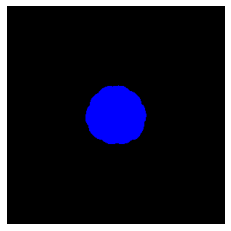

In [87]:
plt.imshow(scene.image)
plt.axis('off')
plt.show()